# Neural Networks
*by [GRAM](https://gra.m-gan.sl), Head of Data Science, Expero Inc*

There's no magic here. 

We've all heard a proselytizing hyperbolist make the an-AI-is-going-to-steal-my-job speech. If you subscribe, look at the following code cell. It demonstrates all the tenets of deep learning. You'll find a simple system composed exclusively of multiply and add operations. That's all that happens inside a neural network. Multiply and add.

A neural network is nothing but a nonlinear system of equations like $y = \sigma(w x + b)$. Seriously. 

In [12]:
#
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm, tnrange

In [13]:
#
def sigmoid(x, forward=True):
    if forward:
        return 1 / (1 + np.exp(-x))
    else: # this is the derivative of sigmoid (for backprop)
        return x * (1 - x)

In [14]:
def neural_network_forward(inpt, weight1, weight2):
    layer1 = np.matmul(inpt, weight1) + bias1 # layer 1 matrix multiplication and addition
    layer1_sigmoid = sigmoid(layer1) # layer 1 nonlinearity

    layer2 = np.matmul(layer1_sigmoid, weight2) + bias2 # layer 2 matrix multiplication and addition
    
    return layer2, layer1_sigmoid, layer1

For those interested, the above cell is a two-deep nested set of nonlinear equations. It looks like this:

\begin{equation*}
y = \sigma(x * w_1 + b_1) * w_2 + b_2,
\end{equation*}

where $x$ is the input, $w_1, w_2, b_1 , b_2$ are weight matrices and bias vectors for layers 1 and 2 respectively, and $\sigma()$ is a nonlinear function (the "sigmoid" function in the rest of this notebook).


For those uninterested, check out this picture of the above neural network with parameters we'll define in subsequent code blocks:

![image](nn_arch.png)

Here we see a simple neural network which takes one number as input (the green neuron) and outputs one number (the red neuron). In the middle (the orange neurons) we have a so-called "hidden layer," which in this case is a 300 number array. Moving information from input layer, to hidden layer, to output layer is as simple as matrix multiplying and adding numbers. In the middle we apply a sigmoid function to each of the numbers.

**We care about this because we can "teach" this simple system to model a mapping between one set of numbers and another set.** For example, we can train this system to output a one when we input a one, a two when we input a two, and an N when we input an N. This is equivalent to building a linear model, but--more interestingly--we could teach it to output a nonlinear model: one maps to one, two maps to four, and N maps to $N^2$. In the following code, we'll train this model to learn a sine function.

How does it "learn?" By adjusting the "w"s and "b"s you see in the equations above. The mechanics here are important, so if your proclivities are mathematical in nature pick through the following code block.

The *TL;DR* is that we show the system a bunch of corresponding input/output pairs we want it to learn, and we show it these pairs thousands of times. Every time we do so, we subtract a little bit off of each of the "w"s and "b"s in the direction that makes the outputs of the network more similar to the known output we're trying to teach it.

In [15]:
def neural_network_backward(inpt, target,
                            layer1, layer1_sigmoid, layer2,
                            weight1, weight2, bias1, bias2,
                            learning_rate):

    weight1gradient = np.zeros(weight1.shape) # weight 1 gradient
    weight2gradient = np.zeros(weight2.shape) # weight 2 gradient

    delta_output = (layer2 - target) # calculate error signal for output layer
    weight2gradient[:,0] = delta_output * layer1_sigmoid # update weight gradient for output layer
    weight2 -= learning_rate * weight2gradient # update weights for output layer

    bias2gradient = delta_output # bias gradient for output layer
    bias2 -= learning_rate * bias2gradient # update biases for output layer
#   ^^^^^ SHOULD BE bias2 NOT bias2gradient
    
    
    delta_hidden = sigmoid(layer1_sigmoid, forward=False) * delta_output * weight2[:,0] # calculate error signal for hidden layer
    weight1gradient[0,:] = delta_hidden * inpt # update gradient for hidden layer
    weight1 -= learning_rate * weight1gradient # update weights for hidden layer
    
    bias1gradient = delta_hidden # bias gradient for hidden layer
    bias1 -= learning_rate * bias1gradient # update biases for hidden layer
#   ^^^^^ SHOULD BE bias1 NOT bias1gradient


The previous code block is called optimization by the backpropagation of gradients. It is the critical piece of thinking which enabled the deep learning revolution. It is the reason Google can translate from Hindi to English. It is the reason the exchange of securities on public markets is no longer performed primarily by humans. It is the reason we can predict the failure of drilling equipment days in advance of failure.

To demonstrate this backpropagation workflow, and thus, that our system can learn, let's try to get the above neural network to learn a sine function, defined in the next code block.

In [16]:
# instantiate some data
x = np.linspace(start=0, stop=2 * np.pi, num=200) # 200 evenly spaced values from 0 to 2 pi
y = np.sin(x) # the sine of the above values

In [17]:
# initialize weights and biases
np.random.seed(1)

weight1 = np.random.uniform(low=-1, high=1, size=(1,300))
weight2 = np.random.uniform(low=-1, high=1, size=(300,1))

# >>> I think it's better to initialize bias to zero?
bias1 = np.zeros(300)
bias2 = np.zeros(1)

In [18]:
#
# pre train plotting
pre_train = []
for i in range(x.shape[0]):
    pre_train.append(neural_network_forward([x[i]], weight1, weight2)[0][0])

One at a time, we expose the network to the input/output pairs (these are labeled x and y respectively in the code). According to our diagram above, the input goes into the green slot and we adjust the orange neurons to make the red slot output from the network a tiny bit closer (0.1%) to the true output of the sine function.

We do this 20,000 times. Every time we do, we output the "mean squared error" (half of the squared distance) between the network's prediction and the groundtruth output from the sine function. After these twenty thousand iterations, or "epochs," we draw out a plot which shows that loss at each step. If the network is learning anything, we expect the loss to decrease, as the predictions are getting closer to the groundtruth.

In [19]:
# training
num_epochs = 5000
learning_rate = 0.01
loss_history = []

for i in tnrange(num_epochs):
    for idx in range(x.shape[0]):
        sample = np.array([x[idx]])
        target = np.array([y[idx]])

        layer2, layer1_sigmoid, layer1 = neural_network_forward(sample, weight1, weight2)

        neural_network_backward(sample, target,
                                layer1, layer1_sigmoid, layer2,
                                weight1, weight2, bias1, bias2,
                                learning_rate)

    loss_history.append(.5 * np.square(layer2 - target))

A Jupyter Widget

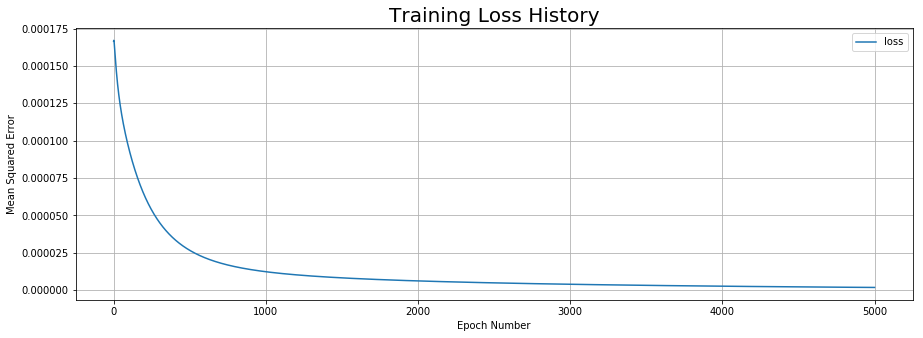

In [20]:
#
# loss plotting
plt.figure(figsize=(15,5))
plt.title('Training Loss History', fontsize=20)
plt.xlabel('Epoch Number')
plt.ylabel('Mean Squared Error')

plt.plot(loss_history, label='loss')

plt.grid()
plt.legend()
plt.show()

The loss decreased dramatically over the course of twenty thousand epochs, so presumably the network has learned something. To test this theory, we'll plot a bunch of network outputs before and after training.

Note that in the next code block that we're actually feeding the network inputs which it hasn't been trained on. In particular, some of these inputs are outside the "span of the input domain," which simply means we're feeding in values outside the [0, 2$\pi$] values we trained on. This is an important concept in statistical modeling known as the "generalizability" of a model.

In [27]:
# calculate predictions on trained values
post_train = []
for i in range(x.shape[0]):
    post_train.append(neural_network_forward([x[i]], weight1, weight2)[0][0])

# calculate predictions on blind values inside and outside of training domain
blind = np.arange(-15,15,.5)
blind_preds = []
for i in range(blind.shape[0]):
    blind_preds.append(neural_network_forward([blind[i]], weight1, weight2)[0][0])

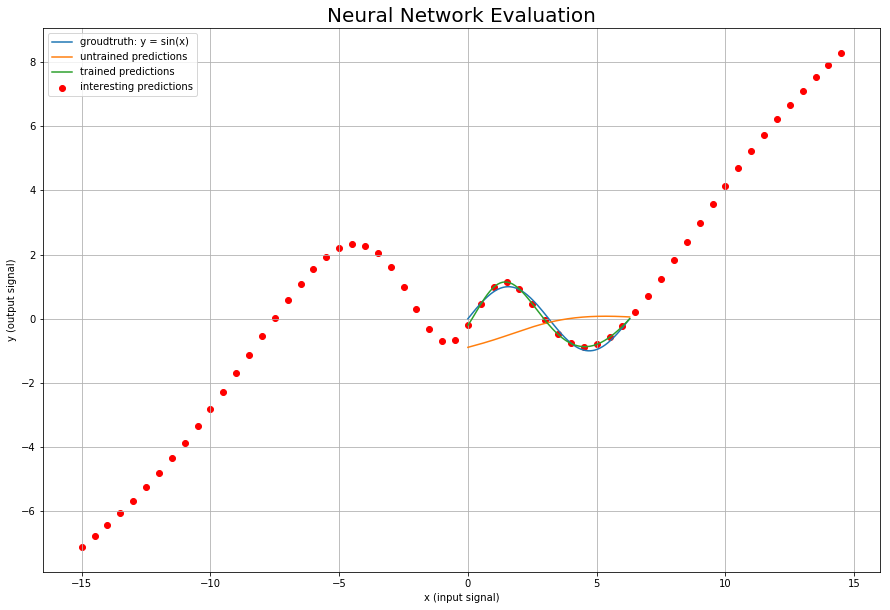

In [28]:
#
plt.figure(figsize=(15,10))
plt.title('Neural Network Evaluation', fontsize=20)
plt.xlabel('x (input signal)')
plt.ylabel('y (output signal)')

plt.plot(x, y, label='groudtruth: y = sin(x)')
plt.plot(x, pre_train, label='untrained predictions')
plt.plot(x, post_train, label='trained predictions')

plt.scatter(blind, blind_preds, color='red', label='interesting predictions')

plt.grid()
plt.legend()
plt.show()
#plt.savefig('output.png', dpi=300)

The blue line is the true sine function we coded. The orange line is the output from the network before training. The green line is the output from the network after training. The red dots are points of interest in the output from the trained model. So, indeed, our neural network has learned to approximate a sine function!

If you're interested in understanding this work more deeply, here are two questions to answer:
1. Why doesn't the blue line match the green line perfectly, especially at the extrema of the original function?
2. Is it interesting that the red dots turn around and head back in the increasing direction on the left side of the plot?

That's it. That's all of deep learning. Multiply, add, apply nonlinearity. No magic. No "intelligence." Just simple arithmetic. Told you.